# Homework 3 Solutions

## Problem 1

Boosting can be treated as fitting a additive classifier in a set of basis functions given by the weak classifiers, by minimizing the exponential loss function given by, $L(y,G(x))=\exp(-yG(x))$. If $\{G_m\}$ is a set of weak classifiers, the task of AdaBoost to find parameters $\{\beta_m\}$, such that the additive classifier given by, $G(x)=\sum_m\beta_mG_m(x)$, minimizes the following:
\begin{align*}
(\beta_m,G_m)=\underset{\beta, G}{\text{argmin}}\sum_{i=1}^Nexp[-y_i(G_{-m}(x_i)+\beta G(x_i))]
\end{align*}
where $G_{-m}(x_i)=\sum_{k\ne m}\beta_kG_k(x_i)$. Further, defining, $w_i^{(m)}=\exp{(-y_iG_{-m}(x_i))}$, we have the objective modified as:

\begin{aligned}
&&\beta_m&=\underset{\beta}{\text{argmin}}\sum_{i=1}^Nw_i^{(m)}e^{-\beta y_iG_m(x_i)}\\
&&&=\underset{\beta}{\text{argmin}}\left[e^{-\beta}\sum_{i:y_i=G_m(x_i)}w_i^{(m)}+e^\beta\sum_{i:y_i\ne G_m(x_i)}w_i^{(m)}\right]\\
&&&=\underset{\beta}{\text{argmin}}\left[(e^\beta-e^{-\beta})\sum_{i=1}^Nw_i^{(m)}\mathbf{1}(y_i\ne G_m(x_i))+e^{-\beta}\sum_{i=1}^Nw_i^{(m)}\right]
\end{aligned}

Further, $err_m=\frac{\sum_{i=1}^Nw_i^{(m)}\mathbf{1}(y_i\ne G_m(x_i))}{\sum_{i=1}^Nw_i^{(m)}}$, substituting this, we have:

\begin{aligned}
&&\beta_m&=\underset{\beta}{\text{argmin}}\left[e^{-\beta}(1-err_m)+e^{\beta}err_m\right]\sum_{i=1}^Nw_i^{(m)}\\
&&&=\frac{1}{2}\log\frac{1-err_m}{err_m}
\end{aligned}


## Problem 2

In [1]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import pydotplus 
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.externals.six import StringIO
from sklearn.base import TransformerMixin
from IPython.display import Image
%matplotlib inline

In [2]:
class DataFrameImputer(TransformerMixin):
    def __init__(self):
        """Impute missing values.
        Columns of dtype object are imputed with the most frequent value 
        in column.
        Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):        
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [3]:
def report_result(clf):
    clf.fit(trainX, trainY)
    trainY_hat_prob = clf.predict_proba(trainX)
    testY_hat_prob = clf.predict_proba(testX)
    trainY_hat = clf.predict(trainX)
    testY_hat = clf.predict(testX)
    misclf_rate_train = 1 - metrics.accuracy_score(trainY,trainY_hat)
    f1_score_train = metrics.f1_score(trainY,trainY_hat)
    AUC_train = metrics.roc_auc_score(trainY, trainY_hat_prob[:, 1])
    misclf_rate_test = 1 - metrics.accuracy_score(testY,testY_hat)
    f1_score_test = metrics.f1_score(testY,testY_hat)
    AUC_test = metrics.roc_auc_score(testY,testY_hat_prob[:, 1])
    return misclf_rate_train, f1_score_train, AUC_train, misclf_rate_test,f1_score_test,AUC_test

Column 27 only has NaN, so we will drop that and also impute missing values since there are too many samples with missing data

In [4]:
# preprocessing the data
original = pd.read_csv("allhyper.data", sep=',', header = None)
allhyper = original.drop([0])
allhyper = allhyper.reset_index(drop=True)
allhyper.columns = original.ix[0].tolist()
# drop the column 27 which only has NaN
allhyper=allhyper.drop(allhyper.columns[[27]], axis=1)
tt=list()
sympton = allhyper.ix[:, 28]
# define the class
for i in range(len(sympton)):
    if sympton[i]=='hyperthyroid.': tt.append(1)
    else: tt.append(0)
labels=pd.DataFrame(tt).ix[:, 0].values
features = allhyper.ix[:, 0:28]
# impute missing values
features = DataFrameImputer().fit_transform(features)

In [5]:
# dummy code the variables
p1 = features.ix[:, 0]
p2 = pd.get_dummies(features.ix[:, 1:17],drop_first=True)
p3 = features.ix[:, 17]
p4 = pd.get_dummies(features.ix[:, 18],prefix='T3Ind',drop_first=True)
p5 = features.ix[:, 19]
p6 = pd.get_dummies(features.ix[:, 20],prefix='TT4Ind',drop_first=True)
p7 = features.ix[:, 21]
p8 = pd.get_dummies(features.ix[:, 22],prefix='T4UInd',drop_first=True)
p9 = features.ix[:, 23]
p10 = pd.get_dummies(features.ix[:, 24],prefix='FTIInd',drop_first=True)
p11 = features.ix[:, 25]
p12 = pd.get_dummies(features.ix[:, 26],prefix='TBGInd')
p13 = pd.get_dummies(features.ix[:, 27],prefix='refSource',drop_first=True)
# concatenate the dummy variables
final = pd.concat([p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,], axis=1)
# convert object dtype to float
for f in final.columns: 
    if final[f].dtype=='object': 
        final[f] = pd.to_numeric(final[f], downcast='float')

In [6]:
# split into 70-30 train/test
trainX, testX, trainY, testY = train_test_split(final, labels, test_size=0.3, random_state=1)

### 2a

In [7]:
clfgini = tree.DecisionTreeClassifier(criterion='gini')
misrate_gini_train,f1_gini_train,AUC_gini_train,misrate_gini_test,f1_gini_test,AUC_gini_test = report_result(clfgini)

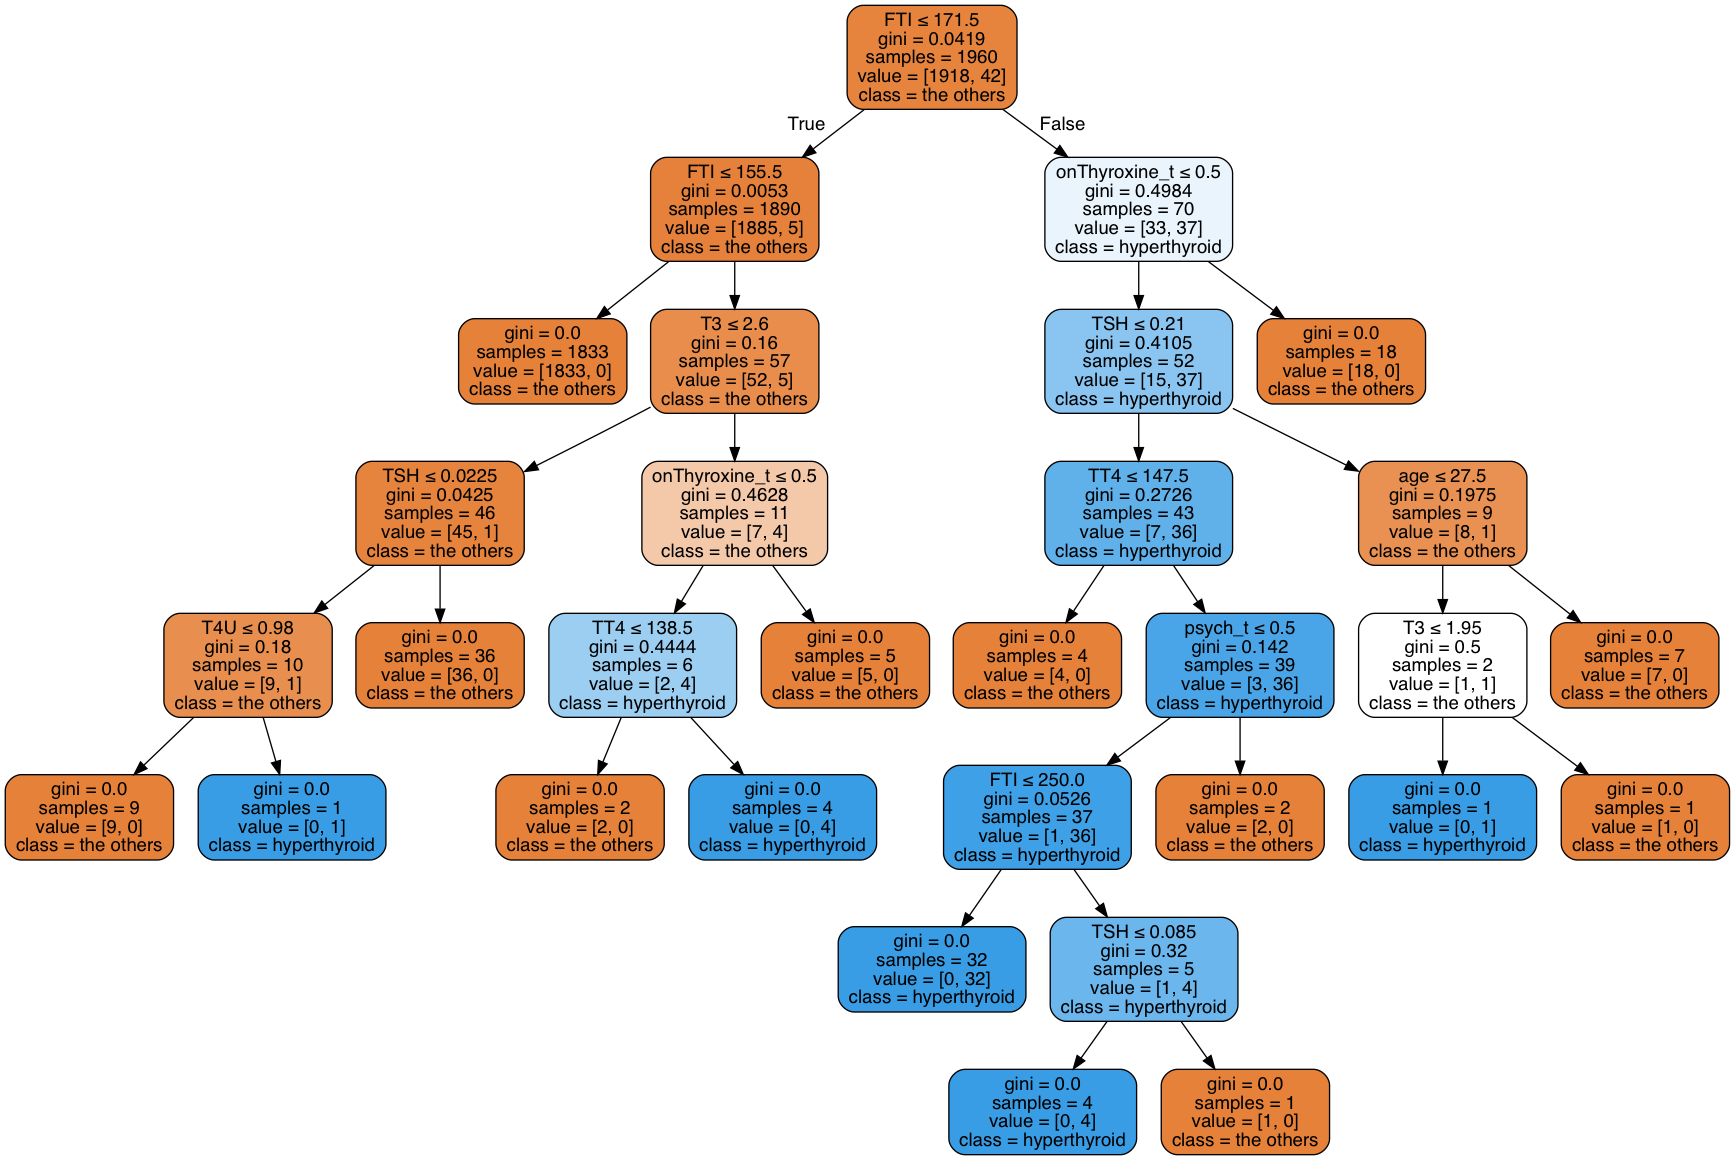

In [8]:
dot_data = StringIO()  
tree.export_graphviz(clfgini, out_file=dot_data,  
                     feature_names=trainX.columns,  
                     class_names=["the others", "hyperthyroid"],  
                     filled=True, rounded=True, special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

### 2b

In [9]:
clfent = tree.DecisionTreeClassifier(criterion='entropy')
misrate_ent_train,f1_ent_train,AUC_ent_train,misrate_ent_test,f1_ent_test,AUC_ent_test = report_result(clfent)

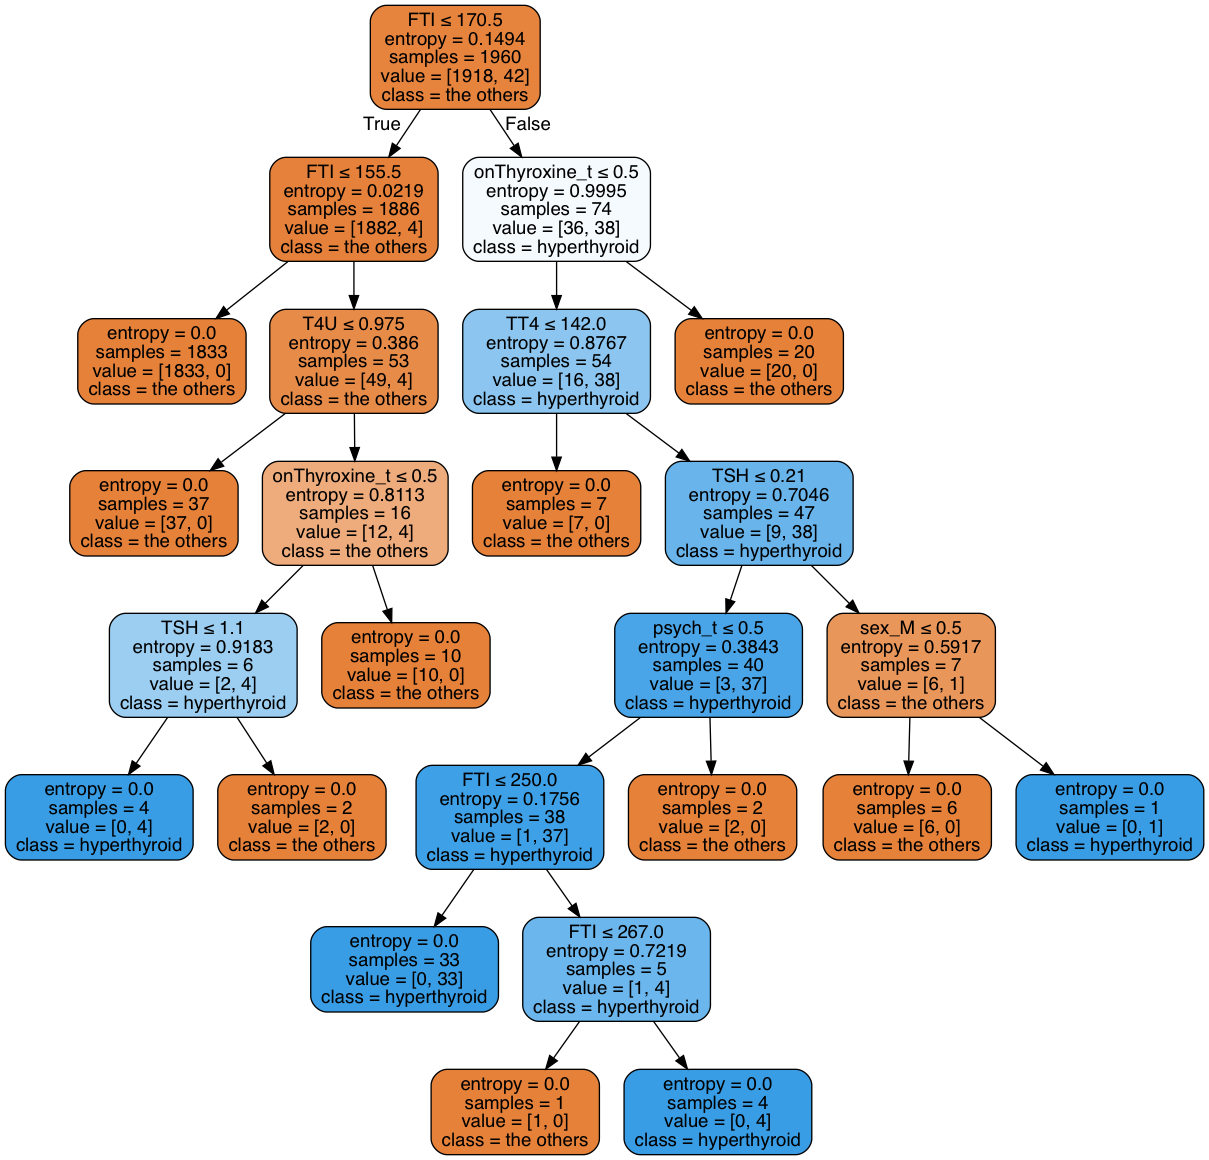

In [10]:
dot_data = StringIO()  
tree.export_graphviz(clfent, out_file=dot_data,  
                     feature_names=trainX.columns,  
                     class_names=["the others", "hyperthyroid"],  
                     filled=True, rounded=True, special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

### 2c

Entropy Criterion: use Grid Search to find the combination of the best maximum depth and minimum number of samples together

In [11]:
# use grid search to best maximum depth and min number of samples
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': np.arange(1, 20), 'min_samples_leaf': np.arange(1,30)}
entTree = GridSearchCV(tree.DecisionTreeClassifier(criterion='entropy'), param_grid, scoring='accuracy')
entTree.fit(trainX, trainY)
print entTree.best_params_

{'max_depth': 4, 'min_samples_leaf': 3}


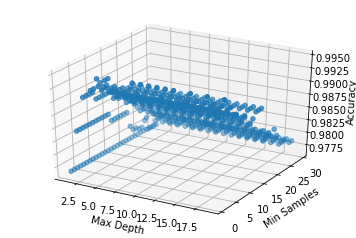

In [12]:
# plot the mean score of the values on a 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
searchResults = pd.DataFrame(entTree.cv_results_)
threedee = plt.figure().gca(projection='3d')
threedee.scatter(searchResults['param_max_depth'], searchResults['param_min_samples_leaf'], searchResults['mean_test_score'])
threedee.set_xlabel('Max Depth')
threedee.set_ylabel('Min Samples')
threedee.set_zlabel('Accuracy')
plt.show()

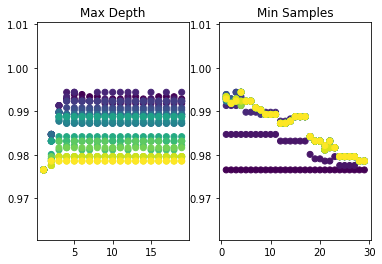

In [13]:
# plot it in 2 dimension
plt.subplot(1,2,1)
plt.scatter(searchResults['param_max_depth'], searchResults['mean_test_score'], c=searchResults['param_min_samples_leaf'])
plt.title('Max Depth')
plt.subplot(1,2,2)
plt.scatter(searchResults['param_min_samples_leaf'], searchResults['mean_test_score'], c=searchResults['param_max_depth'])
plt.title('Min Samples')

In [14]:
# use grid search to best maximum depth and min number of samples
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': np.arange(1, 20), 'min_samples_leaf': np.arange(1,30)}
giniTree = GridSearchCV(tree.DecisionTreeClassifier(criterion='gini'), param_grid, scoring='accuracy')
giniTree.fit(trainX, trainY)
print giniTree.best_params_

{'max_depth': 9, 'min_samples_leaf': 2}


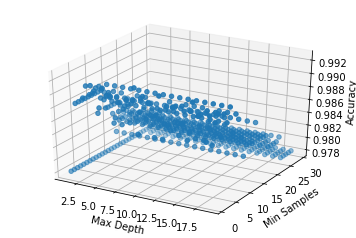

In [15]:
# plot the mean score of the values on a 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
searchResults = pd.DataFrame(giniTree.cv_results_)
threedee = plt.figure().gca(projection='3d')
threedee.scatter(searchResults['param_max_depth'], searchResults['param_min_samples_leaf'], searchResults['mean_test_score'])
threedee.set_xlabel('Max Depth')
threedee.set_ylabel('Min Samples')
threedee.set_zlabel('Accuracy')
plt.show()

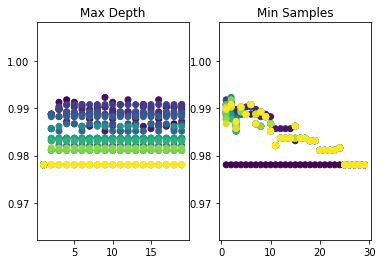

In [16]:
# plot it in 2 dimension
plt.subplot(1,2,1)
plt.scatter(searchResults['param_max_depth'], searchResults['mean_test_score'], c=searchResults['param_min_samples_leaf'])
plt.title('Max Depth')
plt.subplot(1,2,2)
plt.scatter(searchResults['param_min_samples_leaf'], searchResults['mean_test_score'], c=searchResults['param_max_depth'])
plt.title('Min Samples')

In general, we can see that increasing the maximum depth only helps up to a certain point before it plateaus, while increasing the minimum number of samples gets significantly worse overall past 10.

In [17]:
# book keeping to do model comparison
misrate_ginibest_train,f1_ginibest_train,AUC_ginibest_train,misrate_ginibest_test,f1_ginibest_test,AUC_ginibest_test = report_result(giniTree)
misrate_entbest_train,f1_entbest_train,AUC_entbest_train,misrate_entbest_test,f1_entbest_test,AUC_entbest_test = report_result(entTree)

### 2d

In [18]:
pd.DataFrame([[misrate_gini_train,f1_gini_train,AUC_gini_train,misrate_gini_test,f1_gini_test,AUC_gini_test],
              [misrate_ent_train,f1_ent_train,AUC_ent_train,misrate_ent_test,f1_ent_test,AUC_ent_test],
              [misrate_ginibest_train,f1_ginibest_train,AUC_ginibest_train,misrate_ginibest_test,f1_ginibest_test,AUC_ginibest_test],
              [misrate_entbest_train,f1_entbest_train,AUC_entbest_train,misrate_entbest_test,f1_entbest_test,AUC_entbest_test]],
              index = ["gini criterion","entropy criterion","gini best","entropy best"]
             ,columns = ["train error rate", "train f1","train AUC","test error rate", "test f1","test AUC"])

,train error rate,train f1,train AUC,test error rate,test f1,test AUC
gini criterion,0.000000,1.000000,1.000000,0.014286,0.714286,0.870732
entropy criterion,0.000000,1.000000,1.000000,0.011905,0.782609,0.945122
gini best,0.000510,0.988235,0.999777,0.011905,0.782609,0.943171
entropy best,0.003061,0.931818,0.999013,0.010714,0.800000,0.970823


## Problem 3

In [19]:
from sklearn.ensemble import AdaBoostClassifier
nEstimators = [5, 10, 50, 100, 200]
adaBoostValues = []
for nEst in nEstimators:
    aba_cl = AdaBoostClassifier(n_estimators=nEst)
    a1, a2, a3, a4, a5, a6 = report_result(aba_cl)
    adaBoostValues.append([a1, a2, a3, a4, a5, a6])

In [20]:
pd.DataFrame(adaBoostValues,
             index = nEstimators,
             columns = ["train misclfrate", "train f1","train AUC","test misclfrate", "test f1","test AUC" ])

,train misclfrate,train f1,train AUC,test misclfrate,test f1,test AUC
5,0.004592,0.888889,0.998585,0.009524,0.809524,0.986006
10,0.001531,0.965517,0.999913,0.013095,0.755556,0.981524
50,0.000000,1.000000,1.000000,0.010714,0.800000,0.992622
100,0.000000,1.000000,1.000000,0.011905,0.772727,0.991098
200,0.000000,1.000000,1.000000,0.010714,0.800000,0.991280


## Problem 4

### 4a

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

gbValues = []
for nEst in nEstimators:
    gb_cl = GradientBoostingClassifier(n_estimators=nEst)
    a1, a2, a3, a4, a5, a6 = report_result(gb_cl)
    gbValues.append([a1, a2, a3, a4, a5, a6])

In [22]:
pd.DataFrame(gbValues,
             index = nEstimators,
             columns = ["train misclfrate", "train f1","train AUC","test misclfrate", "test f1","test AUC" ])

,train misclfrate,train f1,train AUC,test misclfrate,test f1,test AUC
5,0.004592,0.888889,0.998411,0.008333,0.837209,0.970976
10,0.003571,0.911392,0.998659,0.009524,0.818182,0.970701
50,0.000000,1.000000,1.000000,0.009524,0.818182,0.947348
100,0.000000,1.000000,1.000000,0.009524,0.818182,0.946585
200,0.000000,1.000000,1.000000,0.009524,0.818182,0.946829


### 4b

In [23]:
import xgboost as xgb

xgbValues = []
for nEst in nEstimators:
    gb_cl = xgb.XGBClassifier(n_estimators=nEst)
    a1, a2, a3, a4, a5, a6 = report_result(gb_cl)
    xgbValues.append([a1, a2, a3, a4, a5, a6])

In [24]:
print xgbValues

[[0.0061224489795917991, 0.86046511627906985, 0.99668553552807981, 0.011904761904761862, 0.77272727272727271, 0.97051829268292678], [0.0056122448979591955, 0.87356321839080464, 0.99816897561944484, 0.013095238095238049, 0.75555555555555565, 0.97045731707317062], [0.0020408163265306367, 0.95348837209302328, 0.99972689805849346, 0.0083333333333333037, 0.83720930232558144, 0.99109756097560975], [0.00051020408163260367, 0.98823529411764699, 1.0, 0.00952380952380949, 0.81818181818181823, 0.99158536585365853], [0.0, 1.0, 1.0, 0.010714285714285676, 0.79999999999999993, 0.9924390243902439]]


In [25]:
pd.DataFrame(xgbValues,
             index = nEstimators,
             columns = ["train misclfrate", "train f1","train AUC","test misclfrate", "test f1","test AUC" ])

,train misclfrate,train f1,train AUC,test misclfrate,test f1,test AUC
5,0.006122,0.860465,0.996686,0.011905,0.772727,0.970518
10,0.005612,0.873563,0.998169,0.013095,0.755556,0.970457
50,0.002041,0.953488,0.999727,0.008333,0.837209,0.991098
100,0.000510,0.988235,1.000000,0.009524,0.818182,0.991585
200,0.000000,1.000000,1.000000,0.010714,0.800000,0.992439


## Problem 5

In [26]:
def oob(clf):
    clf.oob_score = True
    clf.fit(trainX,trainY)
    oob_error = 1 - clf.oob_score_
    return oob_error

In [27]:
from sklearn.ensemble import RandomForestClassifier

rfGiniValues = []
for nEst in nEstimators:
    rf_cl = RandomForestClassifier(criterion='gini', n_estimators=nEst)
    a1, a2, a3, a4, a5, a6 = report_result(rf_cl)
    o1 = oob(rf_cl)
    rfGiniValues.append([a1, a2, a3, o1, a4, a5, a6])

rfEntValues = []
for nEst in nEstimators:
    rf_cl = RandomForestClassifier(criterion='entropy', n_estimators=nEst)
    a1, a2, a3, a4, a5, a6 = report_result(rf_cl)
    o1 = oob(rf_cl)
    rfEntValues.append([a1, a2, a3, o1, a4, a5, a6])

/Users/joyceho/miniconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/joyceho/miniconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [28]:
giniPD = pd.DataFrame(rfGiniValues, index = nEstimators,
             columns = ["train misclfrate", "train f1","train AUC","oob error","test misclfrate", "test f1","test AUC" ])
giniPD['type'] = 'gini'
entropyPD = pd.DataFrame(rfEntValues, index = nEstimators,
             columns = ["train misclfrate", "train f1","train AUC","oob error","test misclfrate", "test f1","test AUC" ])
entropyPD['type'] = 'entropy'
pd.concat([giniPD, entropyPD])

,train misclfrate,train f1,train AUC,oob error,test misclfrate,test f1,test AUC,type
5,0.002551,0.936709,0.999969,0.012755,0.011905,0.722222,0.944116,gini
10,0.001020,0.975610,0.999988,0.014796,0.013095,0.731707,0.995457,gini
50,0.000000,1.000000,1.000000,0.009694,0.009524,0.800000,0.995457,gini
100,0.000000,1.000000,1.000000,0.007653,0.009524,0.789474,0.994939,gini
200,0.000000,1.000000,1.000000,0.007143,0.009524,0.809524,0.995061,gini
5,0.000000,1.000000,1.000000,0.012245,0.013095,0.731707,0.993720,entropy
10,0.001020,0.975610,0.999988,0.011735,0.011905,0.722222,0.970976,entropy
50,0.000000,1.000000,1.000000,0.006633,0.009524,0.809524,0.970640,entropy
100,0.000000,1.000000,1.000000,0.006122,0.009524,0.800000,0.969055,entropy
200,0.000000,1.000000,1.000000,0.006122,0.009524,0.800000,0.995213,entropy
